## 操作實例:加州房價資料前處理

In [4]:
# 導入需要套件
import sklearn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer  ##簡單轉換
from sklearn.preprocessing import OrdinalEncoder  ##敘述編碼
from sklearn.preprocessing import OneHotEncoder  ##獨熱編碼
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline  #同時做許多動作時使用
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error  #檢視回歸結果是否良好 mse 均方差
from sklearn.metrics import mean_absolute_error  #平均絕對誤差
from sklearn.tree import DecisionTreeRegressor  #決策樹模型
# 設定相關參數
np.random.seed(42)   #取亂樹初值
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 取得資料

此資料取自加州1990年的人口普查資料，資料集出自1997年Pace，R.Kelley和Ronald Barry題為“Sparse Spatial Autoregressions”的論文中，該論文發表在《Statistics and Probability Letters》期刊上。 他們使用1990年加利福尼亞人口普查數據構建了該數據。 每個普查區組包含一列，是美國人口普查局發布樣本數據的最小地理單位（通常人口為600至3,000人）。最終數據包含20,640個觀測值，因變數是median house value（房價中位數），檔案中欄位如下：
1. longitude:經度
2. latitude:緯度
3. housing median age:房齡中位數
4. total rooms:房間數
5. total bedrooms:臥室數
6. population:人口數
7. households:房屋所有權人數
8. median income:所得中位數
9. median house value:房價中位數

10. ocean_proximity

此資料集幾乎與原始資料集相同，但有兩個區別：
從total bedrooms欄位中隨機刪除了207個值，因此我們可以討論如何處理丟失的數據。 添加了一個附加的分類屬性，稱為10.ocean_proximity，它指出每個普查區組是在海洋附近，在灣區附近，在內陸還是在島上。 這允許討論如何處理分類數據。

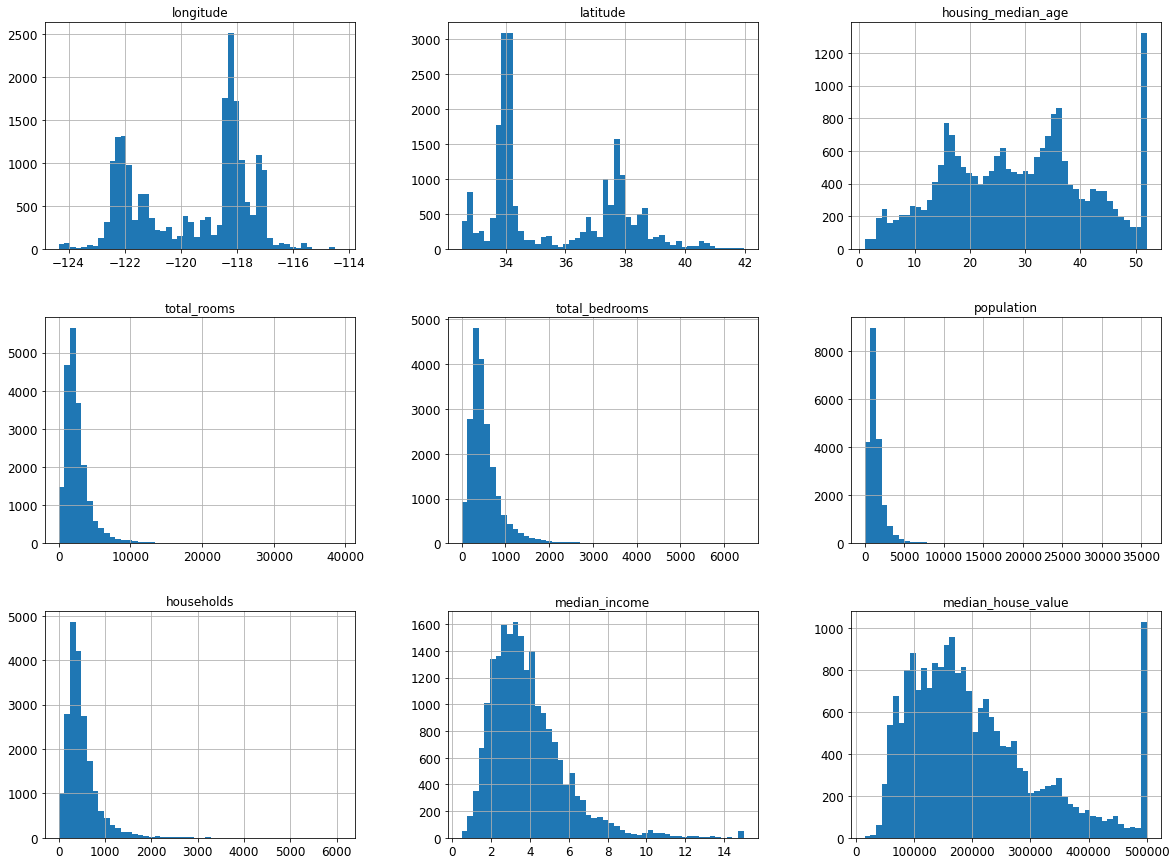

In [6]:
#取得房價資料
housing = pd.read_csv("housing.csv")
# 先看看資料的整體分布情況
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
#呼叫sklearn的train_test_split分割訓練與驗證資料集，測試資料佔20%
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2,   #測試資料集佔20%
                                       random_state=42)

In [8]:
# 使用pandas的cut把median_income切成5个區段，並將區段碼存在'income_cat中
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],  #np.inf  無限大
                               labels=[1, 2, 3, 4, 5])
# 以StratifiedShuffleSplit進行分層的拆分，
# 通過為每個目標類保留與完整集中相同的百分比來創建拆分，避免抽樣不均
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
# 可以看看所得分類中各類比例
strat_test_set["income_cat"].value_counts() / len(strat_test_set)
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [9]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, 
                                       random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [6]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 探索與可視化資料以獲取見解

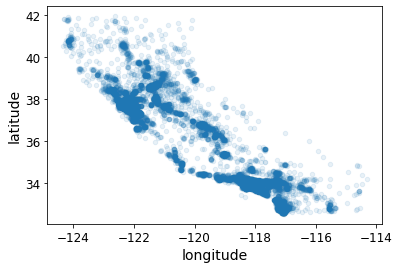

In [11]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()
# 資料越明顯處代表房子越多

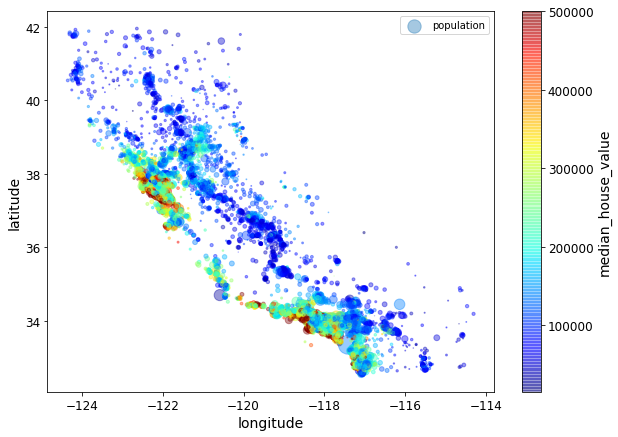

In [12]:
#房價散佈圖
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
plt.show()

<ipython-input-17-e8e2b497f6c7>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)


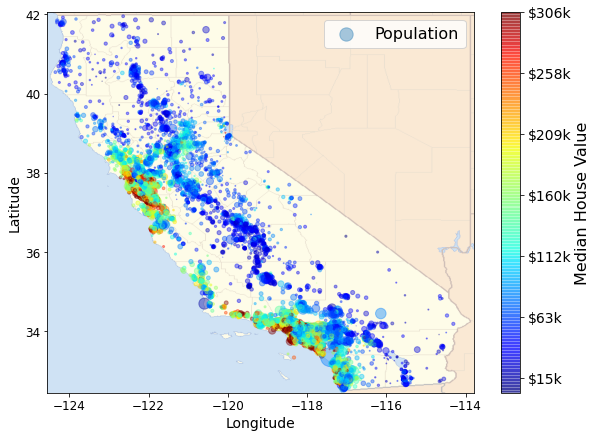

In [17]:
#加州房價圖(套疊加州行政區圖)
california_img=mpimg.imread('1-4california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

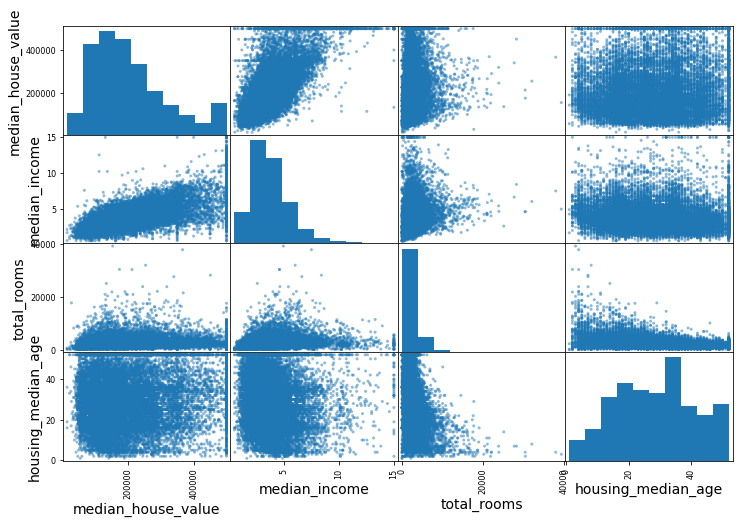

In [10]:
corr_matrix = housing.corr()  #創造相關矩陣  看兩個屬性之間有沒有相關性?
#有共線性 越分散越差
corr_matrix["median_house_value"].sort_values(ascending=False)
#散布矩陣圖
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

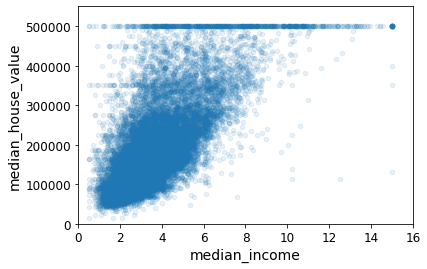

In [18]:
#收入vs房價散布圖
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
plt.show()

In [19]:
# 找出較具代表性的欄位，進行特徵縮放  讓特徵更有意義
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

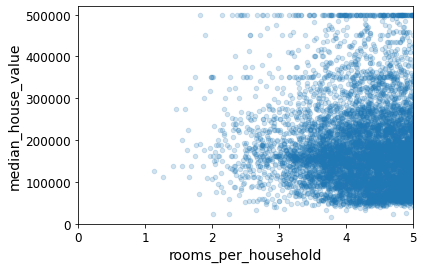

In [20]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()   #房間數跟房價有一點負相關

# 準備給機器學習演算法的資料

In [21]:
# 刪除訓練集的標籤，觀察缺失值資料列
housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()  #找有沒有缺失值  NaN
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN,2
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN,4
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN,4
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND,2
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN,3


In [22]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1  直接drop nan

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat


In [16]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2   把整個row drop

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [23]:
# option 3 以中位數補值
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) 

In [24]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN,2
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN,4
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN,4
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND,2
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN,3


In [26]:
# 建立插補轉換器，用於缺失值補值，此處設定用中位數補值。
imputer = SimpleImputer(strategy="median")
# housing_num = housing.drop("ocean_proximity", axis=1)
housing_num = housing.drop("ocean_proximity", axis=1)  #ocean_proximity 此欄位全部都是str 無法插補 直接drop
imputer.fit(housing_num)  # 針對數值欄位補齊資料 用fit
print("imputer median:",imputer.statistics_)
# housing_num.median().values
print("housing_num.median:",housing_num.median().values)

imputer median: [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409    3.    ]
housing_num.median: [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


Transform the training set:

In [27]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,2.0
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,4.0
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,4.0
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,2.0
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,3.0


In [28]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,2.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,5.0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,2.0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,2.0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,3.0


現在讓我們預處理分類輸入特徵值, `ocean_proximity`:  #處理離海邊近不近的問題

In [29]:
housing_cat = housing[["ocean_proximity"]]
# 採用序數編碼器編碼
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
print(housing_cat_encoded[:10])
print(ordinal_encoder.categories_)

[[0.]
 [0.]
 [4.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [30]:
# 運用獨熱編碼器編碼  加上五個欄位  <1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
print("default:",housing_cat_1hot)
# 將此稀疏陣列以呼叫 toarray() 方法將之轉換成緊密陣列
housing_cat_1hot.toarray()
# 或是在產生 OneHotEncoder設定 sparse=False
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
print("sparse=False :",housing_cat_1hot)
print(cat_encoder.categories_)

default:   (0, 0)	1.0
  (1, 0)	1.0
  (2, 4)	1.0
  (3, 1)	1.0
  (4, 0)	1.0
  (5, 1)	1.0
  (6, 0)	1.0
  (7, 1)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 1)	1.0
  (11, 1)	1.0
  (12, 0)	1.0
  (13, 1)	1.0
  (14, 1)	1.0
  (15, 0)	1.0
  (16, 3)	1.0
  (17, 1)	1.0
  (18, 1)	1.0
  (19, 1)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 1)	1.0
  (24, 1)	1.0
  :	:
  (16487, 1)	1.0
  (16488, 1)	1.0
  (16489, 4)	1.0
  (16490, 3)	1.0
  (16491, 0)	1.0
  (16492, 3)	1.0
  (16493, 1)	1.0
  (16494, 1)	1.0
  (16495, 0)	1.0
  (16496, 1)	1.0
  (16497, 3)	1.0
  (16498, 1)	1.0
  (16499, 0)	1.0
  (16500, 0)	1.0
  (16501, 0)	1.0
  (16502, 4)	1.0
  (16503, 0)	1.0
  (16504, 1)	1.0
  (16505, 1)	1.0
  (16506, 0)	1.0
  (16507, 1)	1.0
  (16508, 1)	1.0
  (16509, 1)	1.0
  (16510, 0)	1.0
  (16511, 3)	1.0
sparse=False : [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


讓我們創建一個自定義轉換器以添加額外的屬性:

In [31]:
# 創建一個自定義轉換器以添加額外的屬性  目的是因為原來有一些欄位沒意義 需自行添加額外屬性
from sklearn.base import BaseEstimator, TransformerMixin

# 加上行索引
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,2,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,5,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,2,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,2,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,3,4.50581,3.04785


現在讓我們建立一個預處理數值屬性的管道:

In [32]:
num_pipeline = Pipeline([     #pipline 才真正開始處理資料
        ('imputer', SimpleImputer(strategy="median")),  #步驟一 簡單編碼轉換
        ('attribs_adder', CombinedAttributesAdder()),   # 步驟二 加屬性
        ('std_scaler', StandardScaler()),  # 步驟三  做標準化
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [33]:
# 將ocean_proximity採用獨熱編碼加入
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
print(housing_prepared.shape)       #  資料處理完成  16512 筆資料  16 個欄位

(16512, 17)


# 建立與訓練模型，接著評估結果

In [34]:
#模型一 線性回歸
lin_reg = LinearRegression()  #線性回歸做訓練
lin_reg.fit(housing_prepared, housing_labels)  

housing_predictions = lin_reg.predict(housing_prepared)  #訓練完拿來預測
lin_mse = mean_squared_error(housing_labels, housing_predictions)   #預測完跑分數
lin_rmse = np.sqrt(lin_mse)  #預測完跑分數
print("RMSE:",lin_rmse)
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
print("MAE:",lin_mae)  #印出平均絕對誤差
# 模型二 決策樹回歸
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("DecisionTreeRegressor RMSE:",tree_rmse)

#決策樹 RMSE : 0.0  沒有誤差

RMSE: 68376.64295459937
MAE: 49508.08205970911
DecisionTreeRegressor RMSE: 0.0
